In [23]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec
import numpy as np

In [ ]:
!pip install --upgrade gensim

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
NYT_sample = open("nyt.txt")
Fox_sample = open("fox.txt")
NYT = NYT_sample.read()
Fox = Fox_sample.read()

In [4]:
n = NYT.replace("\n", " ")
NYT_data = []
# iterate through each sentence in the file
for i in sent_tokenize(n):
    temp = []
    for j in word_tokenize(i):
        temp.append(j.lower())
    NYT_data.append(temp)
f = Fox.replace("\n", " ")
Fox_data = []
# iterate through each sentence in the file
for i in sent_tokenize(f):
    temp = []
    for j in word_tokenize(i):
        temp.append(j.lower())
    Fox_data.append(temp)

In [8]:
model_cbow_Fox = Word2Vec(Fox_data, min_count = 1, window = 5)
model_cbow_NYT = Word2Vec(NYT_data, min_count = 1, window = 5)

In [32]:
# followed this: https://chanind.github.io/nlp/2021/06/10/word2vec-gender-bias.html
gender_pairs = [
    ("she", "he"),
    ("her", "his"),
    ("woman", "man"),
    # ("Mary", "John"),
    ("herself", "himself"),
    ("daughter", "son"),
    ("mother", "father"),
    # ("gal", "guy"),
    ("girl", "boy"),
    ("vagina", "penis"),
    # ("feminine", "masculine"),
]
male_words = ["he","his","man","himself","son","father","boy","penis"]
female_words = ["she","her","woman","herself","daughter","mother","girl","vagina"]

# gender_neutral_words = [
#     "is",
#     "who",
#     "what",
#     "where",
#     "the",
#     "it",
# ]
gender_vectors = [
  model_cbow_Fox.wv[pair[0]] - model_cbow_Fox.wv[pair[1]]
  for pair in gender_pairs
]
gender_vector = np.mean(gender_vectors, axis=0)

In [42]:
queen_gender_projection = np.dot(model_cbow_Fox.wv["queen"], gender_vector)

In [34]:
male_projections = [np.dot(model_cbow_Fox.wv[word], gender_vector) for word in male_words]
female_projections = [np.dot(model_cbow_Fox.wv[word], gender_vector) for word in female_words]

mean_male_projection = np.mean(male_projections)
mean_female_projection = np.mean(female_projections)

In [47]:
test_word = "daughter"
test_word_projection = np.dot(model_cbow_Fox.wv[test_word], gender_vector)

mean_projection = (mean_male_projection + mean_female_projection) / 2
# scale the score so > 0 means female bias, < 0 means male bias
test_word_score = 2 * (test_word_projection - mean_projection) / (mean_female_projection - mean_male_projection)

In [48]:
test_word_score

0.2108008040216702

#TODO: PLOT WORD SCORES

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
X = model_cbow_NYT[model_cbow_NYT.wv.vocab]
df = pd.DataFrame(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.212475,-1.140024,0.541711,-0.075605,0.399896,-0.277549,-0.267174,0.082595,0.664698,0.229543,...,0.674101,-0.500990,1.164985,-0.964844,-0.479339,-0.533142,0.334676,-0.566401,-0.069289,0.172478
1,-0.002839,-0.005465,0.004904,0.002118,0.005836,-0.005127,-0.003294,-0.002360,0.002330,-0.002467,...,0.005400,-0.000437,0.008357,-0.007901,-0.001006,-0.002313,0.003470,0.001600,0.001740,-0.001078
2,0.003646,-0.010879,0.008738,0.001958,0.001585,0.000930,-0.005076,-0.002218,0.002731,-0.002667,...,0.004361,-0.006823,0.007080,-0.010065,-0.003332,-0.006808,0.002520,-0.003592,0.003896,0.000350
3,0.352562,-1.849293,0.876802,-0.102142,0.602854,-0.469089,-0.459757,0.098710,1.069903,0.431918,...,1.101027,-0.827596,1.860606,-1.556998,-0.713526,-0.844292,0.532511,-0.916648,-0.117461,0.279822
4,0.303789,-1.614859,0.763685,-0.096930,0.530653,-0.406438,-0.388517,0.080253,0.934204,0.370882,...,0.968925,-0.718039,1.628003,-1.358521,-0.636218,-0.735226,0.470902,-0.800953,-0.103507,0.243564


In [80]:
X_corr = df.corr()
values, vectors = np.linalg.eig(X_corr)

args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

new_vectors = vectors[:,:2]
neww_X = np.dot(X,new_vectors)

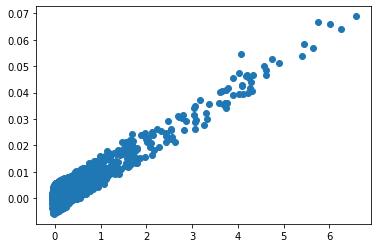

In [83]:
plt.scatter(neww_X[:,0], neww_X[:,1])
vocab = list(model_cbow_NYT.wv.vocab)
# for i, word in enumerate(vocab):
#   plt.annotate(word, xy=(neww_X[i,0],neww_X[i,1]))

In [88]:
# analogy test
model_cbow_Fox.most_similar(positive=["woman","chef"], negative=["man"],topn=5)

[('boyardee', 0.5779699087142944),
 ('prenatal', 0.4195617437362671),
 ('—the', 0.4140213429927826),
 ("'could", 0.4070339798927307),
 ('4.6', 0.4053455591201782)]

In [93]:
# pretty print function
def pp(obj):
    print(pd.DataFrame(obj))
    
def analogy(worda, wordb, wordc):
    result = model_cbow_Fox.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

gendered_stuff = ['queen', 'waitress', 'princess', 'actress', 'nurse']
occupations = [analogy('king', 'man', gender) for gender in gendered_stuff]
pp(zip(gendered_stuff, occupations))

          0       1
0     queen  carter
1  waitress  waiter
2  princess  carter
3   actress    nick
4     nurse  carter


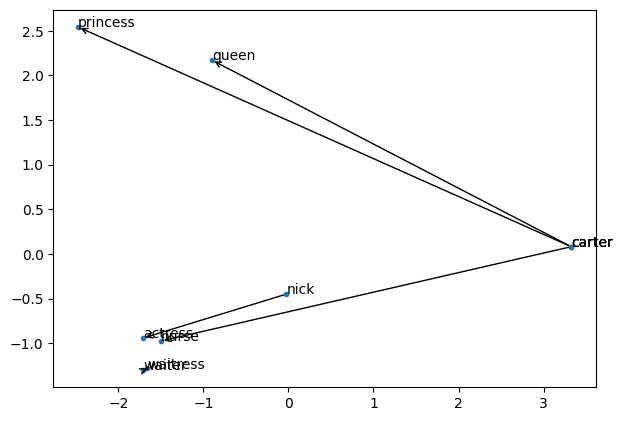

In [94]:
from sklearn.decomposition import PCA

def plot_data(orig_data, labels):
    pca = PCA(n_components=2)
    data = pca.fit_transform(orig_data)
    plt.figure(figsize=(7, 5), dpi=100)
    plt.plot(data[:,0], data[:,1], '.')
    for i in range(len(data)):
        plt.annotate(labels[i], xy = data[i])
    for i in range(len(data)//2):
        plt.annotate("",
                xy=data[i],
                xytext=data[i+len(data)//2],
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3")
        )
       
labels = gendered_stuff + occupations
data = [model_cbow_Fox[w] for w in labels]
plot_data(data, labels)